In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from nvstatsrecorder.callbacks import NVStats

def reset_session(use_amp=True, use_xla=True):
    try:
        del model
    except:
        pass
    tf.keras.backend.clear_session()
    tf.config.optimizer.set_jit(use_xla)
    tf.config.optimizer.set_experimental_options({"auto_mixed_precision": use_amp})

In [2]:
#assert len(tf.config.list_physical_devices("GPU")) > 0
print("TensorFlow version:", tf.__version__)
print("cuDNN version:", os.environ["CUDNN_VERSION"])
print("CUDA version:", os.environ["CUDA_VERSION"])

TensorFlow version: 2.1.0
cuDNN version: 7.6.5.32
CUDA version: 10.1.243


In [3]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        
def normalize(ndarray):
    ndarray = ndarray.astype("float32")
    ndarray = (ndarray/127.5) - 1
    return ndarray

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

num_classes = np.max(y_train) + 1

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train = normalize(x_train)
x_test = normalize(x_test)

num_train = x_train.shape[0]

In [5]:
def return_model(conv, act="relu", pad="same", ini="he_uniform"):
    model = tf.keras.models.Sequential([
        conv(128, (3, 3), kernel_initializer=ini, padding=pad, activation=act, input_shape=x_train.shape[1:]),
        conv(128, (3, 3), kernel_initializer=ini, padding=pad, activation=act),
        conv(128, (3, 3), kernel_initializer=ini, padding=pad, activation=act),
        conv(128, (3, 3), kernel_initializer=ini, padding=pad, activation=act),
        layers.MaxPooling2D(pool_size=(4, 4)),
        layers.BatchNormalization(fused=True),
        layers.Flatten(),
        layers.Dense(10, kernel_initializer=ini),
        layers.Activation("softmax")
    ])
    opt = tf.keras.optimizers.Adam()
    opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt, "dynamic")
    model.compile(loss="categorical_crossentropy",
                  optimizer=opt,
                  metrics=["acc"])
    return model

In [6]:
BATCH_SIZE = 128

## Normal Convolution

In [7]:
reset_session()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
train_dataset = train_dataset.prefetch(128)

test_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

_ = train_dataset.take(8)

steps_per_epoch = int(num_train // BATCH_SIZE) + 1

Throttle Reasons: []
* Params: 528778
* Mean SM Util: 57.5
* Mean Mem Util: 17.9
* Peak FPS: 11123
* Acc: 0.80987585


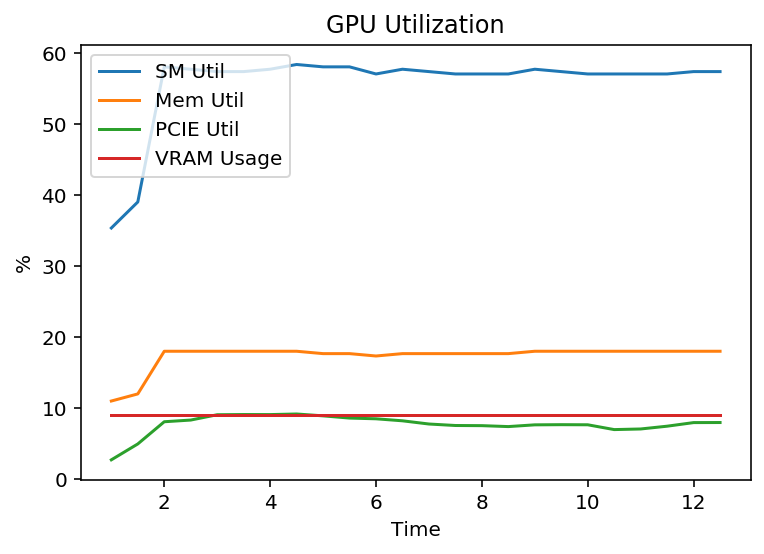

In [8]:
nv_stats = NVStats(gpu_index=3, interval=0.5)
time_history = TimeHistory()

model = return_model(layers.Conv2D)

train_log = model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
                      epochs=2, verbose=0,
                      callbacks=[])

train_log = model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
                      epochs=3, verbose=0,
                      callbacks=[nv_stats, time_history])

nv_stats_recorder = nv_stats.recorder
stats = nv_stats_recorder.get_data()
mean_sm_util = round(np.mean(stats["sm_util_history"][2:-2]), 1)
mean_mem_util = round(np.mean(stats["mem_util_history"][2:-2]), 1)

peak_fps = int(steps_per_epoch*BATCH_SIZE/min(time_history.times))

print("* Params:", model.count_params())
print("* Mean SM Util:", mean_sm_util)
print("* Mean Mem Util:", mean_mem_util)
print("* Peak FPS:", peak_fps)
print("* Acc:", model.evaluate(test_dataset, verbose=0)[1])

nv_stats_recorder.plot_gpu_util(smooth=3)

## Depthwise Separable Convolution

In [9]:
reset_session()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
train_dataset = train_dataset.prefetch(128)

test_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

_ = train_dataset.take(8)

steps_per_epoch = int(num_train // BATCH_SIZE) + 1

Throttle Reasons: []
* Params: 135973
* Mean SM Util: 61.2
* Mean Mem Util: 38.4
* Peak FPS: 9094
* Acc: 0.7224359


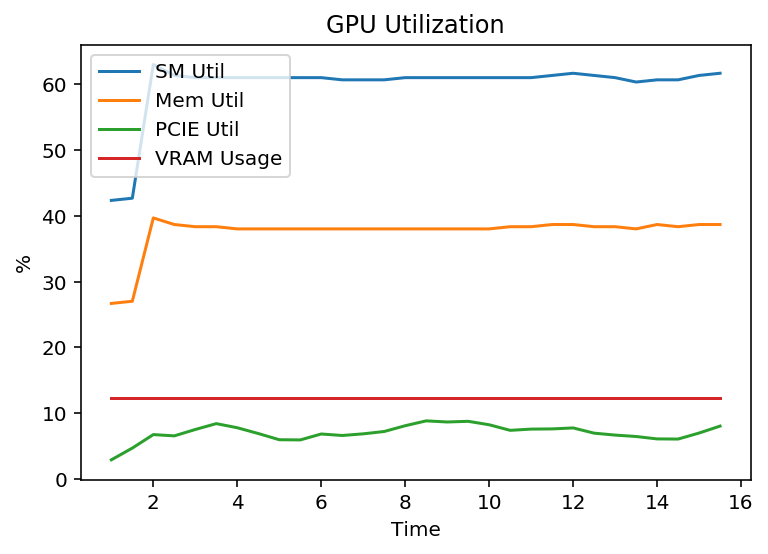

In [12]:
nv_stats = NVStats(gpu_index=3, interval=0.5)
time_history = TimeHistory()

model = return_model(layers.SeparableConv2D)

train_log = model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
                      epochs=2, verbose=0,
                      callbacks=[])

train_log = model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
                      epochs=3, verbose=0,
                      callbacks=[nv_stats, time_history])

nv_stats_recorder = nv_stats.recorder
stats = nv_stats_recorder.get_data()
mean_sm_util = round(np.mean(stats["sm_util_history"][2:-2]), 1)
mean_mem_util = round(np.mean(stats["mem_util_history"][2:-2]), 1)

peak_fps = int(steps_per_epoch*BATCH_SIZE/min(time_history.times))

print("* Params:", model.count_params())
print("* Mean SM Util:", mean_sm_util)
print("* Mean Mem Util:", mean_mem_util)
print("* Peak FPS:", peak_fps)
print("* Acc:", model.evaluate(test_dataset, verbose=0)[1])

nv_stats_recorder.plot_gpu_util(smooth=3)